In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from datetime import timedelta
from datetime import datetime, date

from scipy.sparse import csr_matrix

from math import sqrt

from tqdm import tqdm_notebook as tqdm

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import plotly.express as px

In [2]:
FILES_DIR = '../files/'
sample = pd.read_csv(FILES_DIR + 'sample_df.csv')

In [3]:
sample_df = sample.copy()

In [4]:
# binary로 문제를 풀어볼거여서 구매 말고는 -1로
sample_df['rating'] = sample_df['event_name']
re_name = {'rating' : {'click_item':-1, 'like_item':-1, 'add_to_cart':-1, 'purchase_success':1}}
sample_df = sample_df.replace(re_name)
####################################
####################################
sample_df = sample_df[sample_df['gender'] != 'un_gender']
####################################
####################################
sample_df.loc[sample_df['age'] <= 17, 'age(Group)'] = '00 ~ 17'

sample_df.loc[(sample_df['age'] >= 18) &\
               (sample_df['age'] <= 24), 'age(Group)'] = '18 ~ 24'

sample_df.loc[(sample_df['age'] >= 25) &\
               (sample_df['age'] <= 35), 'age(Group)'] = '25 ~ 35'

sample_df.loc[(sample_df['age'] >= 36) &\
               (sample_df['age'] <= 44), 'age(Group)'] = '36 ~ 44'

sample_df.loc[(sample_df['age'] >= 45) &\
               (sample_df['age'] <= 54), 'age(Group)'] = '45 ~ 54'

sample_df.loc[sample_df['age'] >= 55, 'age(Group)'] = '55 ~ 99'
####################################
####################################
sample_df['event_timestamp'] = pd.to_datetime(sample_df['event_timestamp'])
sample_df['event_timestamp(weekday)'] = sample_df['event_timestamp'].dt.day_name()

In [5]:
sample_df['dayname_feature'] = np.where((sample_df['event_timestamp(weekday)'] == 'Sunday')
                                        |(sample_df['event_timestamp(weekday)'] == 'Monday')
                                        |(sample_df['event_timestamp(weekday)'] == 'Tuesday')
                                        |(sample_df['event_timestamp(weekday)'] == 'Wednesday') , 1, 0)

In [6]:
# 'dayname_feature'
col_list_2 = ['event_name', 'user_no', 'item_no', 'country', 'region', 'platform', 
'event_timestamp_month', 'event_timestamp_day', 'event_timestamp_hour',
'category1_name', 'category2_name', 'gender', 'age', 'age(Group)', 
'event_timestamp(weekday)', 'dayname_feature']

raw_data_2 = sample_df[col_list_2]

In [7]:
X_data = pd.get_dummies(raw_data_2, columns=col_list_2)
y_data = sample_df['rating']

In [8]:
import scipy
X_sparse = scipy.sparse.csr_matrix(X_data.values)

In [9]:
# Compute negative log likelihood between prediction and label
def log_loss(pred, y):
    return np.log(np.exp(-pred * y) + 1.0)

In [10]:
# Update gradients
def sgd(X, y, n_samples, n_features,
                w0, w, v, n_factors, learning_rate, reg_w, reg_v):
    data = X.data
    indptr = X.indptr
    indices = X.indices
    loss = 0.0

    for i in range(n_samples):
        pred, summed = predict(X, w0, w, v, n_factors, i)
        
        # calculate loss and its gradient
        loss += log_loss(pred, y[i])
        loss_gradient = -y[i] / (np.exp(y[i] * pred) + 1.0)
    
        # update bias/intercept term
        w0 -= learning_rate * loss_gradient

        # update weight
        for index in range(indptr[i], indptr[i + 1]):
            feature = indices[index]
            w[feature] -= learning_rate * (loss_gradient * data[index] + 2 * reg_w * w[feature])

        # update factor
        for factor in range(n_factors):
            for index in range(indptr[i], indptr[i + 1]):
                feature = indices[index]
                term = summed[factor] - v[factor, feature] * data[index]
                v_gradient = loss_gradient * data[index] * term
                v[factor, feature] -= learning_rate * (v_gradient + 2 * reg_v * v[factor, feature])
    
    loss /= n_samples
    return loss


In [11]:
def predict(X, w0, w, v, n_factors, i):
    data = X.data
    indptr = X.indptr
    indices = X.indices
    """predicting a single instance"""
    summed = np.zeros(n_factors)
    summed_squared = np.zeros(n_factors)

    # linear output w * x
    pred = w0
    for index in range(indptr[i], indptr[i + 1]):
        feature = indices[index]
        pred += w[feature] * data[index]

    # factor output
    for factor in range(n_factors):
        for index in range(indptr[i], indptr[i + 1]):
            feature = indices[index]
            term = v[factor, feature] * data[index]
            summed[factor] += term
            summed_squared[factor] += term * term

        pred += 0.5 * (summed[factor] * summed[factor] - summed_squared[factor])

    # gradient update할 때, summed는 독립이므로 re-use 가능
    return pred, summed

In [12]:
# Train Factorization Machine
# X -> sparse csr_matrix, y -> label
def fit(X, y, config):
    epochs = config['num_epochs']
    num_factors = config['num_factors']
    learning_rate = config['learning_rate']
    reg_weights = config['reg_weights']
    reg_features = config['reg_features']

    num_samples, num_features = X.shape
    weights = np.zeros(num_features) # -> w
    global_bias = 0.0 # -> w0
    
    # latent factors for all features -> v
    feature_factors = np.random.normal(size = (num_factors, num_features))

    epoch_loss = []
    for epoch in range(epochs):
        loss = sgd(X, y, num_samples, num_features,
                            global_bias, weights,
                            feature_factors, num_factors,
                            learning_rate, reg_weights, reg_features)
        print(f'[epoch: {epoch+1}], loss: {loss}')

        epoch_loss.append(loss)
      
    return epoch_loss


In [13]:
config = {
    "num_epochs": 10,
    "num_factors": 10,
    "learning_rate": 0.01,
    "reg_weights": 0.01,
    "reg_features": 0.01
}

In [14]:
epoch_loss = fit(X_sparse, y_data.values, config)

[epoch: 1], loss: 0.18928458901145184
[epoch: 2], loss: 0.04843236966940443
[epoch: 3], loss: 0.0368753726293114
[epoch: 4], loss: 0.03181742806095803
[epoch: 5], loss: 0.028047138147774094
[epoch: 6], loss: 0.02523910563791164
[epoch: 7], loss: 0.023163808509052385
[epoch: 8], loss: 0.021548153054551895
[epoch: 9], loss: 0.02028344605642066
[epoch: 10], loss: 0.01926688795249438


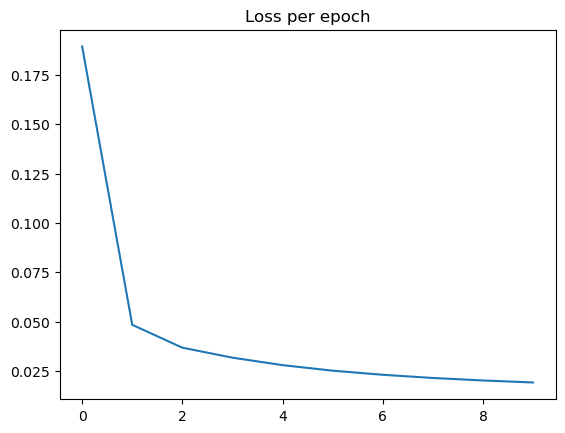

In [15]:
plt.plot(epoch_loss)
plt.title('Loss per epoch')
plt.show()